# Causal DS Project

## Installation

In [145]:
# Import packages
from itertools import permutations
from dowhy import gcm
from dowhy import CausalModel

import os
import hyppo
import dowhy
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import numpy as np
import pandas as pd
import pingouin as pg
import conditional_independence


np.random.seed(0)


## Tutorial 1&2

In this part, the LUCAS0 dataset is introduced, and functions and other aspects of the 1st & 2nd tutorial notebooks are applied to this dataset.


In [146]:

# Use this if you are using the local version
df = pd.read_csv('../../data/lucas0_train.csv')

### Loading in dataset

In [147]:
data = df.rename(columns={"Smoking": "Smk", "Yellow_Fingers": "Fng", "Anxiety": "Anx", "Peer_Pressure": "Prs","Genetics": "Gen", "Attention_Disorder": "Atn", "Born_an_Even_Day": "Day", "Car_Accident": "Car", "Fatigue": "Ftg", "Allergy": "Alg", "Coughing": "Cou", "Lung_cancer": "Cnc"})
data.head()

,Smk,Fng,Anx,Prs,Gen,Atn,Day,Car,Ftg,Alg,Cou,Cnc
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


### First look at the dataset & Basic EDA

The dataset contains syntetic data, obtained by artifically generating it from causal Bayesian networks with binary variables. The causal graph was already given.

The graph used is a DAG, which means there are no cycles. We assume causal sufficiency, with 2000 points in the dataset.

TODO: create bar chart (like in independence test section) for all variables

In [148]:
# Data contains no null values
df.isnull().sum()

Smoking               0
Yellow_Fingers        0
Anxiety               0
Peer_Pressure         0
Genetics              0
Attention_Disorder    0
Born_an_Even_Day      0
Car_Accident          0
Fatigue               0
Allergy               0
Coughing              0
Lung_cancer           0
dtype: int64

In [149]:
# Data contains only values of 0 and 1
df.nunique()

Smoking               2
Yellow_Fingers        2
Anxiety               2
Peer_Pressure         2
Genetics              2
Attention_Disorder    2
Born_an_Even_Day      2
Car_Accident          2
Fatigue               2
Allergy               2
Coughing              2
Lung_cancer           2
dtype: int64

In [150]:
# We plot a correlation matrix between the variables.
# There's a strong correlation between Yellow_Fingers and Smoking - to be expected, since yellow fingers are a symptom of smoking.
# At the same time, half of smokers have Lung_cancer.
# As expected, born_an_even_day has no relation with any other variable. It has no causal link in the graph either.
# Regarding Car Accidents,  both Fatigue and Attention Disorder have a strong correlation with it, with 0.46 and 0.3 respectively.

corr = df.corr()
corr.style.format("{:.2}").background_gradient(axis=0, vmin=-1, vmax=1)

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
Smoking,1.0,0.77,0.4,0.15,0.01,0.0041,-0.022,0.051,0.16,0.036,0.26,0.49
Yellow_Fingers,0.77,1.0,0.31,0.11,-0.0041,0.0068,-0.0062,0.049,0.12,0.047,0.21,0.38
Anxiety,0.4,0.31,1.0,0.003,0.0063,-0.015,-0.038,0.031,0.051,0.018,0.14,0.19
Peer_Pressure,0.15,0.11,0.003,1.0,0.02,0.015,-0.007,0.024,0.028,-0.005,0.05,0.057
Genetics,0.01,-0.0041,0.0063,0.02,1.0,0.27,-0.022,0.15,0.1,-0.0082,0.14,0.23
Attention_Disorder,0.0041,0.0068,-0.015,0.015,0.27,1.0,-0.021,0.3,0.033,0.02,0.054,0.068
Born_an_Even_Day,-0.022,-0.0062,-0.038,-0.007,-0.022,-0.021,1.0,-0.031,-0.028,-0.033,-0.028,-0.012
Car_Accident,0.051,0.049,0.031,0.024,0.15,0.3,-0.031,1.0,0.46,0.038,0.21,0.17
Fatigue,0.16,0.12,0.051,0.028,0.1,0.033,-0.028,0.46,1.0,0.094,0.46,0.37
Allergy,0.036,0.047,0.018,-0.005,-0.0082,0.02,-0.033,0.038,0.094,1.0,0.31,-0.026


### Creating graph in NetworkX

We will use NetworkX ([documentation](https://networkx.org/documentation/stable/reference/introduction.html)) for the creation of our causal network. This network can then be loaded into the DoWhy package, and be used for causal inference/prediction and so on.

### LUCAS0 Causal Graph

All covariates will be indicated with abbreviations in the graph below.


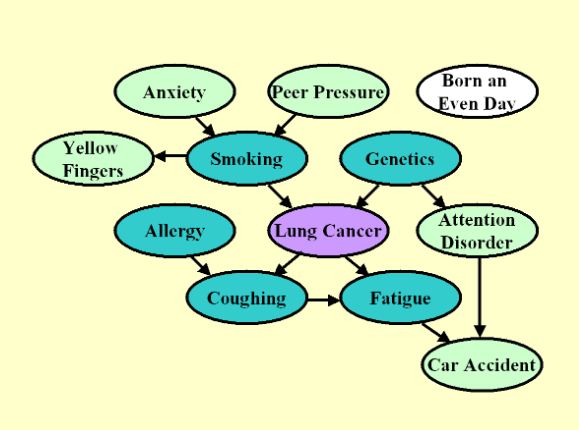

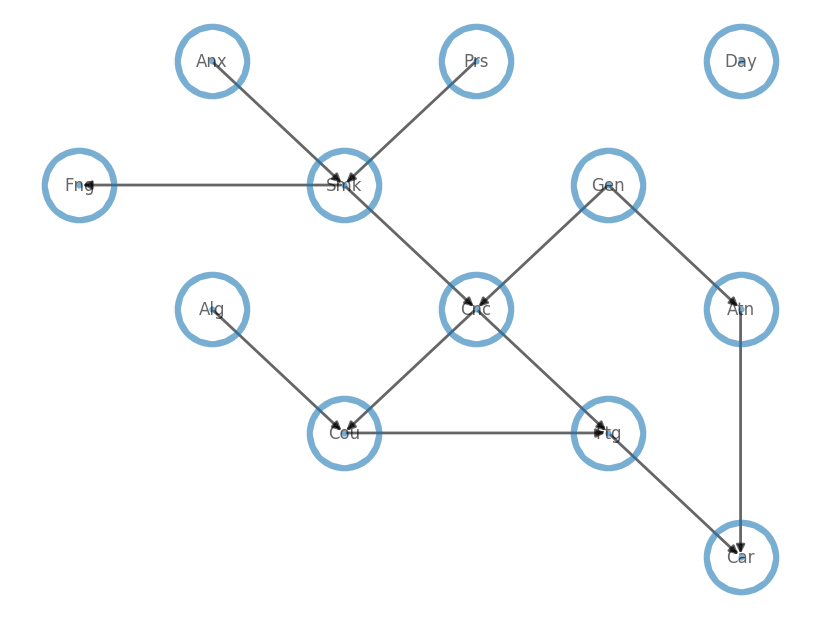

In [151]:
# we import networkx and create a directed graph
G = nx.DiGraph()


G.add_nodes_from(['Anx', 'Fng', 'Prs', 'Smk', 'Alg', 'Cou', 'Cnc', 'Gen',
                 'Day', 'Ftg', 'Atn', 'Car'])

G.add_edges_from([('Anx','Smk'), ('Prs','Smk'), ('Smk','Fng'), ('Smk','Cnc'), 
                  ('Alg','Cou'), ('Cou','Ftg'), ('Ftg','Car'), ('Cnc','Cou'),
                 ('Cnc','Ftg'), ('Gen','Cnc'), ('Gen', 'Atn'), ('Atn', 'Car')])

# we can visualise this graph (choosing node positions, colours, and sizes to make it more clear) 
# and save it to a .gml format (for using DoWhy later)
pos = {'Cnc': (0, 0),  'Anx': (-2, 2), 'Prs': (0, 2), 'Day': (2, 2),
         'Fng': (-3, 1), 'Smk': (-1, 1), 'Gen': (1, 1),
         'Alg': (-2, 0), 'Atn': (2, 0), 
         'Cou': (-1, -1), 'Ftg': (1,-1),
         'Car': (2, -2),}

plt.figure(figsize=(8,6))
nx.draw(G, pos= pos, with_labels=True, node_size=20, node_shape="o", alpha=0.6, linewidths=50,  width=2, arrowsize=12)
nx.write_gml(G, "assignment_graph.gml")

In [152]:
# Check the number of nodes and edges in the graph
print("Current number of nodes in the graph is ", G.number_of_nodes())
print("Current number of edges in the graph is ", G.number_of_edges())

Current number of nodes in the graph is  12
Current number of edges in the graph is  12


In [153]:
# Generate GML format as string for input into DoWhy
G_gml = ''.join(nx.generate_gml(G))
print(G_gml)

graph [  directed 1  node [    id 0    label "Anx"  ]  node [    id 1    label "Fng"  ]  node [    id 2    label "Prs"  ]  node [    id 3    label "Smk"  ]  node [    id 4    label "Alg"  ]  node [    id 5    label "Cou"  ]  node [    id 6    label "Cnc"  ]  node [    id 7    label "Gen"  ]  node [    id 8    label "Day"  ]  node [    id 9    label "Ftg"  ]  node [    id 10    label "Atn"  ]  node [    id 11    label "Car"  ]  edge [    source 0    target 3  ]  edge [    source 2    target 3  ]  edge [    source 3    target 1  ]  edge [    source 3    target 6  ]  edge [    source 4    target 5  ]  edge [    source 5    target 9  ]  edge [    source 6    target 5  ]  edge [    source 6    target 9  ]  edge [    source 7    target 6  ]  edge [    source 7    target 10  ]  edge [    source 9    target 11  ]  edge [    source 10    target 11  ]]


In [154]:
# This is not necessary for this part; identifying and estimating 
# effects happens more elaborately in following parts

# Model our system

# causal_model = gcm.StructuralCausalModel(G)

# gcm.auto.assign_causal_mechanisms(causal_model, data)

# model = CausalModel(
#     data=data["df"],
#     treatment=data["treatment_name"],
#     outcome=data["outcome_name"],
#     graph=data["gml_graph"])

# # Step 2: Identify causal effect and return target estimands
# identified_estimand = model.identify_effect()

# # Step 3: Estimate the target estimand using a statistical method.
# estimate = model.estimate_effect(identified_estimand,
#                                  method_name="backdoor.propensity_score_matching")

# # Step 4: Refute the obtained estimate using multiple robustness checks.
# refute_results = model.refute_estimate(identified_estimand, estimate,
                                      #  method_name="random_common_cause")


### D-separation
Here we check our graph for D-separation on certain conditioning sets.

Root and target nodes are marked red. Below, all paths between root and target are visualized as red.

Definition of D-Separation:

> **D-separation**: The nodes $X$ and $Y$ are d-separated by $Z \subseteq V\setminus\{X,Y\}$ if all paths between them are blocked by $Z$.

> **Blocking**: A path between nodes $X$ and $Y$ is blocked by $Z \subseteq V\setminus\{X,Y\}$ if at least one of the following conditions holds:
> - There is a non-collider on the path that is in $Z$
> - There is a collider node $k$ on the path, such that $k \notin Z$ and $Desc(k) \cap A = \emptyset$

> **Collider**: $k$ on a path $\pi = (x,...,y)$ is a non-endpoint node ($k \neq x,y$) such that the path $\pi$ contans $\to k \leftarrow$. Non-endpoint nodes without this patthern are non-colliders.

Note that the D-separation code below is written from scratch, which is not a requirement for our project, but I simply left it in from the tutorial code and use it to print some results of D-separation on our data.

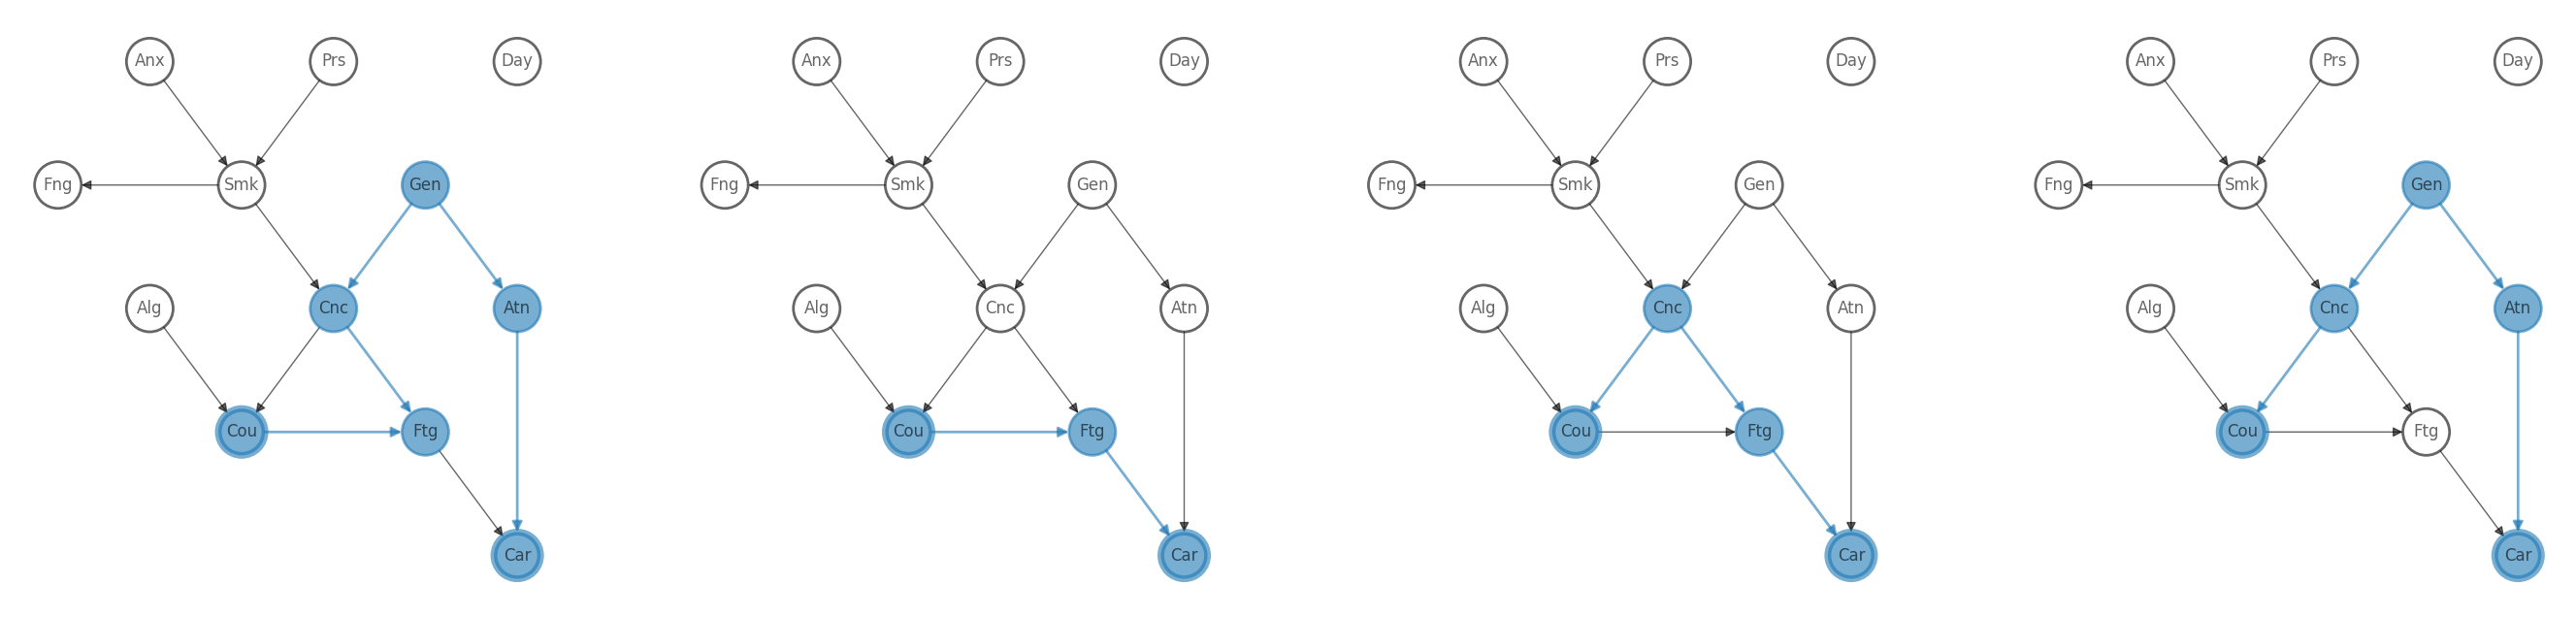

In [155]:
def get_all_paths(G, source_node, target_node):
      return list(nx.all_simple_paths(G.to_undirected(), source=source_node, target=target_node))

def visualize_paths(G, all_paths, source_node, target_node):
    if len(all_paths) == 1:
        nrows = 1
        ncols = 1
        x_size = 5
        y_size = 4
  
    else:
        nrows = len(all_paths)//5 if len(all_paths)%5==0 else len(all_paths)//5 + 1
        ncols = len(all_paths) if len(all_paths) <= 4 else 5
        x_size = ncols * 4 + 1
        y_size = nrows * 4

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(x_size*2, y_size*2))

    if len(all_paths) == 1:
        path = all_paths[0]
        edges_on_path = [(source, target) for source, target in zip(path[:-1], path[1:])]
        edges_on_path_reversed = [(target, source) for source, target in edges_on_path]
        edges_on_path += edges_on_path_reversed

        edge_color = ['#1f78b4' if edge in edges_on_path else 'black' for edge in G.edges()]
        edge_widths = [2.5 if edge in edges_on_path else 1 for edge in G.edges()]
        node_color = ['#1f78b4' if node in path else 'white' for node in G.nodes()]
        edge_colors = ['#1f78b4' if node in path else 'black' for node in G.nodes()]
        line_widths = [5 if node in [source_node, target_node] else 1.5 for node in G.nodes()]
        nx.draw(G,pos=pos, with_labels=True, ax=axs, edge_color=edge_color,node_size=1200, node_color=node_color, edgecolors = edge_colors, node_shape="o", alpha=0.6, linewidths=line_widths, width=edge_widths, arrowsize=15)
        fig.savefig("./graph.png", transparent=True)

#         axs.set_title(path)
  
    else:
        axs = axs.flatten()
        for path, ax in zip(all_paths, axs):
            edges_on_path = [(source, target) for source, target in zip(path[:-1], path[1:])]
            edges_on_path_reversed = [(target, source) for source, target in edges_on_path]
            edges_on_path += edges_on_path_reversed

            edge_color = ['#1f78b4' if edge in edges_on_path else 'black' for edge in G.edges()]
            edge_widths = [2 if edge in edges_on_path else 1 for edge in G.edges()]
            node_color = ['#1f78b4' if node in path else 'white' for node in G.nodes()]
            edge_colors = ['#1f78b4' if node in path else 'black' for node in G.nodes()]
            line_widths = [5 if node in [source_node, target_node] else 2 for node in G.nodes()]
            nx.draw(G,pos=pos, with_labels=True, ax=ax, edge_color=edge_color,node_size=1200, node_color=node_color, edgecolors = edge_colors, node_shape="o", alpha=0.6, linewidths=line_widths,  width=edge_widths, arrowsize=15)
            # fig.savefig("./graph.png", transparent=True)

#             ax.set_title(path)

source_node, target_node = "Cou", "Car"
# visualize_paths(G, all_paths = get_all_paths(G, 'Smk', 'Car'), source_node = 'Smk', target_node = 'Car')
visualize_paths(G, all_paths = get_all_paths(G, source_node, target_node), source_node = source_node, target_node = target_node)



In [156]:
# Check if a node is an end-point on the path

# all_paths = get_all_paths(G, source_node='Alg', target_node='Ftg')

# def is_endpoint(path, node):
#     return node in [path[0], path[-1]]

# print('Node {} is an endpoint on path {}: {}'.format('Alg', all_paths[1], is_endpoint(all_paths[1], 'Alg')))
# print('Node {} is an endpoint on path {}: {}'.format('CnC', all_paths[2], is_endpoint(all_paths[2], 'Cnc')))

In [157]:
# Get previous and successor nodes on path
# def get_prev_and_succ(path, node):
#     ind = path.index(node)
#     prev, succ = path[ind-1], path[ind+1]
#     return prev, succ

# print('Previous and successor nodes of node {} on path {} are nodes {} and {} respectively'.format(
#     'Cnc', all_paths[1], *get_prev_and_succ(all_paths[1], 'Cnc')))

In [158]:
# # Check whether a node is a collider on a path
# def is_collider(G, path, node):
#     if node not in path:  # Check if node is on path
#         return False
#     elif is_endpoint(path, node):  # Check if non-endpoint
#         return False
#     else: # Check if both edges point towards the node
#         prev, succ = get_prev_and_succ(path, node)
#         return (prev, node) in G.edges() and (succ, node) in G.edges()

# print('{} is a collider on path {}: {}'.format('Cou', all_paths[0], is_collider(G, all_paths[0], 'Cou')))
# print('{} is a collider on path {}: {}'.format('Cou', all_paths[1], is_collider(G, all_paths[1], 'Cou')))
# print('{} is a collider on path {}: {}'.format('Cou', all_paths[2], is_collider(G, all_paths[2], 'Cou')))

In [159]:
# # Get all colliders on a path
# def get_colliders(G, path):
#     colliders = set([node for node in path if is_collider(G, path, node)])
#     return colliders


# print('Colliders on path {}: {}'.format(all_paths[0], get_colliders(G, all_paths[0])))
# print('Colliders on path {}: {}'.format(all_paths[1], get_colliders(G, all_paths[1])))
# print('Colliders on path {}: {}'.format(all_paths[2], get_colliders(G, all_paths[2])))

In [160]:
# # Check whether a node is a non-collider on a path
# def is_non_collider(G, path, node):
#     if node not in path:  # Check if node is on path
#         return False
#     elif is_endpoint(path, node):  # Check if non-endpoint
#         return False
#     else:
#         return not is_collider(G, path, node)


# print('{} is a non-collider on path {}: {}'.format('Cou', all_paths[0], is_non_collider(G, all_paths[0], 'Cou')))
# print('{} is a non-collider on path {}: {}'.format('Cou', all_paths[1], is_non_collider(G, all_paths[1], 'Cou')))
# print('{} is a non-collider on path {}: {}'.format('Cou', all_paths[2], is_non_collider(G, all_paths[2], 'Cou')))

In [161]:
# # Get all non-colliders on a path
# def get_non_colliders(G, path):
#     non_colliders = set([node for node in path if is_non_collider(G, path, node)])
#     return non_colliders


# print('Non-olliders on path {}: {}'.format(all_paths[0], get_non_colliders(G, all_paths[0])))
# print('Non-Colliders on path {}: {}'.format(all_paths[1], get_non_colliders(G, all_paths[1])))
# print('Non-Colliders on path {}: {}'.format(all_paths[2], get_non_colliders(G, all_paths[2])))

In [162]:
# # Get all descendants of a node
# def get_descendants(G, node):
#     return nx.descendants(G, node).union([node])


# print('Descendants of node {} are {}'.format('Cnc', get_descendants(G, 'Cnc')))
# print('Descendants of node {} are {}'.format('Ftg', get_descendants(G, 'Ftg')))

In [163]:
# def is_blocked(G, path, z):
#     # First condition
#     non_colliders = get_non_colliders(G, path)
#     cond1 = len(non_colliders.intersection(z)) > 0
    
#     # Second condition
#     # All colliders
#     colliders = get_colliders(G, path)
#     # Colliders not in z
#     colliders_not_in_z = colliders.difference(z)
#     # Colliders not in z such that none of their descendants are in z
#     colliders_not_in_z_with_desc_not_in_z = [node for node in colliders_not_in_z if len(get_descendants(G, node).intersection(z)) == 0]
#     cond2 = len(colliders_not_in_z_with_desc_not_in_z) > 0

#     return cond1 or cond2

# print('Path {} is blocked by nodes {}: {}'.format(all_paths[0], [], is_blocked(G, all_paths[0], [])))
# print('Path {} is blocked by nodes {}: {}'.format(all_paths[0], ['Cou'], is_blocked(G, all_paths[0], ['Cou'])))
# print('Path {} is blocked by nodes {}: {}'.format(all_paths[1], ['Cnc', 'Gen'], is_blocked(G, all_paths[1], ['Cnc', 'Gen'])))
# print('Path {} is blocked by nodes {}: {}'.format(all_paths[1], ['Atn'], is_blocked(G, all_paths[1], ['Atn'])))
# print('Path {} is blocked by nodes {}: {}'.format(all_paths[2], ['Cou'], is_blocked(G, all_paths[2], ['Cou'])))
# print('Path {} is blocked by nodes {}: {}'.format(all_paths[2], ['Cou', 'Cnc'], is_blocked(G, all_paths[2], ['Cou', 'Cnc'])))

In [164]:
# def is_d_separated(G, x, y, z):
#     if x in z or y in z:
#         raise ValueError('Source and target nodes cannot be in the conditioning set')
#     paths = nx.all_simple_paths(G.to_undirected(), source=x, target=y)
#     blocked = [is_blocked(G, path, z) for path in paths]
#     return all(blocked)


# print('Nodes {} and {} are d-separated by {}: {}'.format('Alg', 'Ftg', ['Cnc'], is_d_separated(G, 'Alg', 'Ftg', ['Cnc'])))
# print('Nodes {} and {} are d-separated by {}: {}'.format('Alg', 'Ftg', ['Cou', 'Cnc', 'Gen'], is_d_separated(G, 'Alg', 'Ftg', ['Cou', 'Cnc', 'Gen'])))
# print('Nodes {} and {} are d-separated by {}: {}'.format('Cou', 'Car', ['Gen'], is_d_separated(G, 'Cou', 'Car', ['Gen'])))
# print('Nodes {} and {} are d-separated by {}: {}'.format('Cou', 'Ftg', ['Cnc'], is_d_separated(G, 'Cou', 'Ftg', ['Cnc'])))
# print('Nodes {} and {} are d-separated by {}: {}'.format('Cou', 'Ftg', ['Atn'], is_d_separated(G, 'Cou', 'Ftg', ['Atn'])))

Now that you understand how d-separation works, **you should use the much more efficient and tested function provided by NetworkX**

In [165]:
# print('Nodes {} and {} are d-separated by {}: {}'.format('Alg', 'Ftg', ['Cnc'], nx.algorithms.d_separated(G=G, x=set(['Alg']), y=set(['Ftg']), z=set(['Cnc']))))
# and so on

### Independence tests on LUCAS0 variables

Below we check if it holds that
$$
A \perp_d B | C \Rightarrow X_A \perp \!\!\! \perp X_B | X_C
$$

using different variables in our data set, and also check which variables are independent, or correlated with each other.

Our null-hypothesis is always that the two variables are independent,$X\!\perp\!\!\!\perp Y$, while the alternative hypothesis is that they are dependent, $X \not \!\perp\!\!\!\perp Y$.


We reject the null-hypothesis given a p-value <= 0.05, giving an indication for (conditional) dependence, while p-value > 0.05 implies no rejection of the null, indicating independence. 

We also calculate partial correlation, i.e. the degree of association between x and y, after removing the effect of one or more controlling variables (covar, or 𝑍), using pingouin.

#### Independence tests for Y's ancestor nodes

In [166]:
# create count tables for lung cancer and its parent nodes, and concatenate all of them
# smoking_vs_lc = pd.crosstab(index = data['Smk'], columns = data['Cnc']).rename({0:"No Smoking", 1:"Smoking"})
# genetics_vs_lc = pd.crosstab(index = data['Gen'], columns = data['Cnc']).rename({0:"No  Genetic Predisposition", 1:" Genetic Predisposition"})
# anxiety_vs_lc = pd.crosstab(index = data['Anx'], columns = data['Cnc']).rename({0:"No Anxiety", 1:"Anxiety"})
# peer_pressure_vs_lc = pd.crosstab(index = data['Prs'], columns = data['Cnc']).rename({0:"No Peer Pressure", 1:"Peer Pressure"})

# cross_tabbed_df = pd.concat([smoking_vs_lc,genetics_vs_lc,anxiety_vs_lc,peer_pressure_vs_lc])



# G.add_nodes_from(['Anx', 'Fng', 'Prs', 'Smk', 'Alg', 'Cou', 'Cnc', 'Gen',
#                  'Day', 'Ftg', 'Atn', 'Car'])

In [167]:
coughing_vs_car = pd.crosstab(index = data["Cou"], columns = data[target_node]).rename({0:"No Coughing", 1:"Coughing"})
cancer_vs_car = pd.crosstab(index = data['Cnc'], columns = data[target_node]).rename({0:"No Lung Cancer", 1:"Lung Cancer"})
genetic_vs_car = pd.crosstab(index = data['Gen'], columns = data[target_node]).rename({0:"No Genetic Predisposition", 1:"Genetic Predispositionics"})
fatigue_vs_car = pd.crosstab(index = data['Ftg'], columns = data[target_node]).rename({0:"No Fatigue", 1:"Fatigue"})
attention_disorder_vs_car = pd.crosstab(index = data['Atn'], columns = data[target_node]).rename({0:"No Attention Disorder", 1:"Attention Disorder"})
cross_tabbed_df = pd.concat([coughing_vs_car, cancer_vs_car, genetic_vs_car, fatigue_vs_car, attention_disorder_vs_car])

In [168]:
cross_tabbed_df

Car,0,1
No Coughing,250,349
Coughing,304,1097
No Lung Cancer,222,335
Lung Cancer,332,1111
No Genetic Predisposition,522,1199
Genetic Predispositionics,32,247
No Fatigue,328,198
Fatigue,226,1248
No Attention Disorder,502,853
Attention Disorder,52,593


<Figure size 640x480 with 0 Axes>

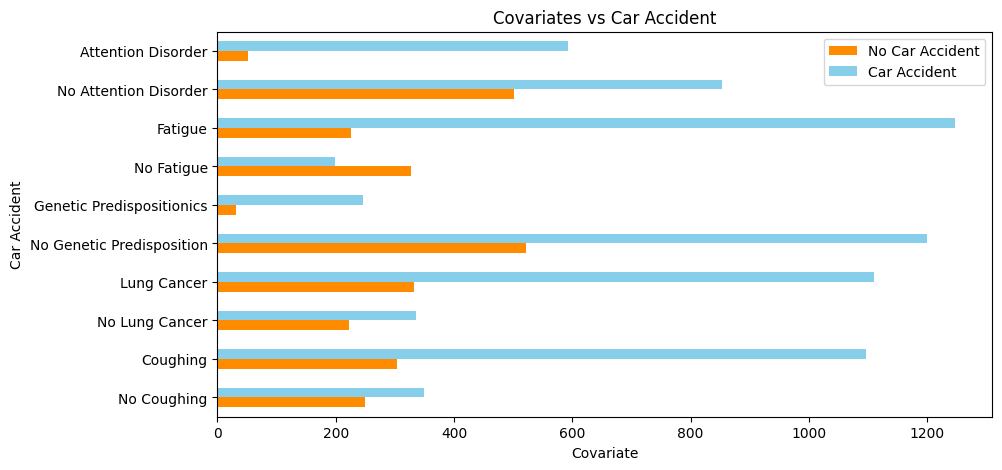

In [169]:
# Visualize variable relations as grouped bar chart between lung cancer and its parent nodes
plt.clf()
# plt.gca().set_aspect('equal')
cross_tabbed_df.plot.barh(color=['darkorange','skyblue'],figsize = (10, 5))
plt.legend(['No Car Accident', 'Car Accident'])

# #add vertical lines to separate covariates visually
# for x in [1.5, 5.5]:
#     # plt.axvline(x = x, color = 'black', linestyle='dashed')
#     plt.axhspan(x, x+2, facecolor='g', alpha=0.2)

plt.xlabel('Covariate')
plt.ylabel('Car Accident')
plt.title('Covariates vs Car Accident')
plt.show()


In [170]:
coughing_vs_car = pd.crosstab(index = data["Cou"], columns = data[target_node], normalize="index").rename({0:"No Coughing", 1:"Coughing"})
cancer_vs_car = pd.crosstab(index = data['Cnc'], columns = data[target_node],normalize="index").rename({0:"No Lung Cancer", 1:"Lung Cancer"})
genetic_vs_car = pd.crosstab(index = data['Gen'], columns = data[target_node], normalize="index").rename({0:"No Genetic Predisposition", 1:"Genetic Predispositionics"})
fatigue_vs_car = pd.crosstab(index = data['Ftg'], columns = data[target_node], normalize="index").rename({0:"No Fatigue", 1:"Fatigue"})
attention_disorder_vs_car = pd.crosstab(index = data['Atn'], columns = data[target_node], normalize="index").rename({0:"No Attention Disorder", 1:"Attention Disorder"})
cross_tabbed_df1 = pd.concat([coughing_vs_car, cancer_vs_car, genetic_vs_car, fatigue_vs_car, attention_disorder_vs_car])

In [171]:
cross_tabbed_df1

Car,0,1
No Coughing,0.417362,0.582638
Coughing,0.216988,0.783012
No Lung Cancer,0.398564,0.601436
Lung Cancer,0.230076,0.769924
No Genetic Predisposition,0.303312,0.696688
Genetic Predispositionics,0.114695,0.885305
No Fatigue,0.623574,0.376426
Fatigue,0.153324,0.846676
No Attention Disorder,0.370480,0.629520
Attention Disorder,0.080620,0.919380


<Figure size 640x480 with 0 Axes>

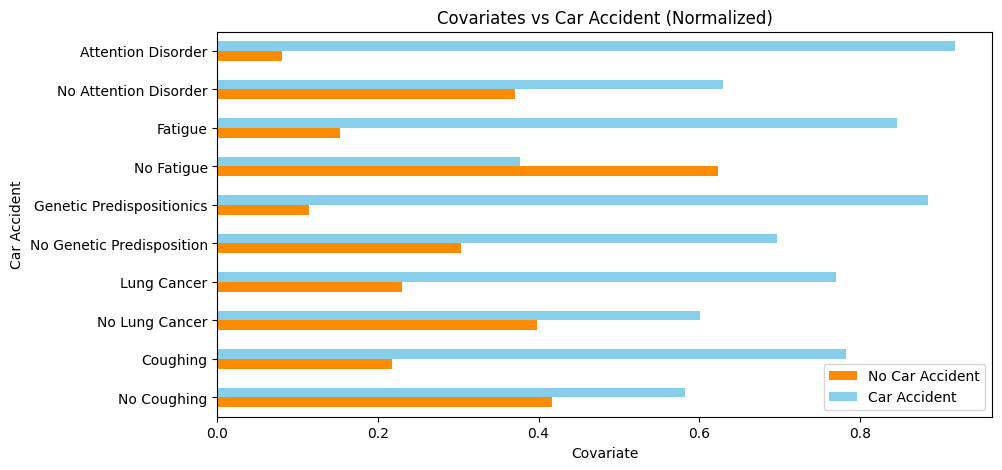

In [172]:
# Visualize variable relations as grouped bar chart between lung cancer and its parent nodes
plt.clf()
# plt.gca().set_aspect('equal')
cross_tabbed_df1.plot.barh(color=['darkorange','skyblue'],figsize = (10, 5))
plt.legend(['No Car Accident', 'Car Accident'])

# #add vertical lines to separate covariates visually
# for x in [1.5, 5.5]:
#     # plt.axvline(x = x, color = 'black', linestyle='dashed')
#     plt.axhspan(x, x+2, facecolor='g', alpha=0.2)

plt.xlabel('Covariate')
plt.ylabel('Car Accident')
plt.title('Covariates vs Car Accident (Normalized)')
plt.show()


The graph above indicates that Y and all of Y's parent nodes are dependent on eachother if we do not condition on anything, and they are also d-connected without a conditioning set. Thus, $x_i \not\perp_d Y, \forall x_i \in \{S,G,A,PP\}$ (d-connected), and also $x_i \not \!\perp\!\!\!\perp Y, \forall x_i \in \{S,G,A,PP\}$ (marginally dependent). We test the marginal correlations below using [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) test.

In [173]:
coughing_marg = pg.partial_corr(data=data, x='Cou', y=target_node, covar=[], method='pearson').rename(index={"pearson":"Cou,Car"})
cancer_marg = pg.partial_corr(data=data, x='Cnc', y=target_node, covar=[], method='pearson').rename(index={"pearson":"Cnc,Car"})
genetic_marg = pg.partial_corr(data=data, x='Gen', y=target_node, covar=[], method='pearson').rename(index={"pearson":"Gen,Car"})
fatigue_marg = pg.partial_corr(data=data, x='Ftg', y=target_node, covar=[], method='pearson').rename(index={"pearson":"Ftg,Car"})
atn_discorder_marg = pg.partial_corr(data=data, x='Atn', y=target_node, covar=[], method='pearson').rename(index={"pearson":"Atn,Car"}) 
marginals_parents = pd.concat([coughing_marg,cancer_marg,genetic_marg,fatigue_marg, atn_discorder_marg])
marginals_parents

,n,r,CI95%,p-val
"Cou,Car",2000,0.205086,"[0.16, 0.25]",1.957568e-20
"Cnc,Car",2000,0.168768,"[0.13, 0.21]",3.022308e-14
"Gen,Car",2000,0.146027,"[0.1, 0.19]",5.321500e-11
"Ftg,Car",2000,0.462627,"[0.43, 0.5]",1.257269e-106
"Atn,Car",2000,0.302760,"[0.26, 0.34]",1.140011e-43


For every parent node of Y, the test returns a significant (very small) p-value, thus, for every parent node, we reject the null hypothesis that the parent node and $Y$ are independent, and establish that they are dependent, which is what we expected.

Regarding conditioning sets, according to the graph above, $Y$ and $A$ (Anxiety), and Y and $PP$ (Peer Pressure) are d-separated by $S$ (Smoking); $A \perp_d Y | S$ and $PP \perp_d Y | S$, which should imply that $A$ and $Y$, and $PP$ and $Y$ are conditionally independent given $S$; $A \perp\!\!\!\perp Y | S$ and $PP \perp\!\!\!\perp Y | S$. Let's check if this also holds true based on the data.

In [174]:
coughing_marg = pg.partial_corr(data=data, x='Cou', y=target_node, covar=['Atn'], method='pearson').rename(index={"pearson":"Cou, Car given Atn"})
genetic_marg = pg.partial_corr(data=data, x='Gen', y=target_node, covar=['Atn'], method='pearson').rename(index={"pearson":"Gen, Car given Atn"})
marginals_parents = pd.concat([coughing_marg, genetic_marg])
marginals_parents

,n,r,CI95%,p-val
"Cou, Car given Atn",2000,0.198281,"[0.16, 0.24]",3.598968e-19
"Gen, Car given Atn",2000,0.070461,"[0.03, 0.11]",1.620137e-03


Indeed, the p-values are not significant, which means we do not reject the null-hypothesis of Anxiety and Y, and Peer Pressure and Y being independent given smoking (i.e. they are (most likely) independent conditional on smoking).

For all possible marginal/conditional (in)dependencies among Lung Cancer and its predecessors nodes via Smoking, and among Lung Cancer and Genetics, we run the tests below.

In [175]:
def test_all(df, vars=['X', 'Car', 'Z']):
    # Marginal
    for var1, var2 in permutations(vars, 2):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[], method='pearson')['p-val'].item()
        print('{} and {}: p-value is {}'.format(var1, var2, p_val))

    # Conditional
    for var1, var2, cond in permutations(vars, 3):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[cond], method='pearson')['p-val'].item()
        print('{} and {} given {}: p-value is {}'.format(var1, var2, cond, p_val))

In [176]:
print("tests between Y and its pre-decessors via S:")
test_all(data, vars=['Cou','Cnc', 'Gen', 'Ftg', 'Atn','Car'])


tests between Y and its pre-decessors via S:
Cou and Cnc: p-value is 6.156919002953028e-137
Cou and Gen: p-value is 7.131224273674561e-10
Cou and Ftg: p-value is 3.2777218187809026e-105
Cou and Atn: p-value is 0.015482219456914952
Cou and Car: p-value is 1.957567625029803e-20
Cnc and Cou: p-value is 6.1569190029530295e-137
Cnc and Gen: p-value is 6.443645849221805e-25
Cnc and Ftg: p-value is 2.0352022137767444e-65
Cnc and Atn: p-value is 0.0022338152156248497
Cnc and Car: p-value is 3.0223081287443455e-14
Gen and Cou: p-value is 7.131224273674614e-10
Gen and Cnc: p-value is 6.443645849221988e-25
Gen and Ftg: p-value is 8.144951485034246e-06
Gen and Atn: p-value is 2.0614183287538143e-34
Gen and Car: p-value is 5.3215000156732025e-11
Ftg and Cou: p-value is 3.2777218187809026e-105
Ftg and Cnc: p-value is 2.0352022137766867e-65
Ftg and Gen: p-value is 8.144951485034246e-06
Ftg and Atn: p-value is 0.13860514137815022
Ftg and Car: p-value is 1.2572694487383608e-106
Atn and Cou: p-value is 

None of the results above can be called surprising.


### Post-interventional distributions

BONUS: For the 6th segment of the project, there is an option to run interventional vs observational tests. This is only asked in case the dataset contains interventional data. Since the standard LUCAS dataset does not contain interventional data, we do not run interventions here. We could look at the second version of the LUCAS dataset to test on interventions, or try to experiment with generating some interventional data on our own and run observational vs interventional distribution tests.

## Tutorial 3



### Backdoor Criterion

The backdoor criterion allows us to identify the variables on which we need to condition to calculate our causal estimates. We identify these variables by looking at 'backwards' paths from the treatment variable.

The criterion is given as follows:\
Given an ordered pair of variables ($X$, $Y$) in a directed acyclic graph G, a set of variables **Z** satisfies the backdoor criterion relative to ($X$, $Y$) if no node in **Z** is a descendant of $X$, and **Z** blocks every path between $X$ and $Y$ that contains an arrow into $X$.

This definition was taken from: https://medium.data4sci.com/causal-inference-part-xi-backdoor-criterion-e29627a1da0e

Let's create a network and manually identify adjustment sets based on the backdoor criterion. We want to find effect of Lung Cancer $Can$ on Car Accidents $Acc$.

We can start by identifying the descendants of $Can$, as these must <u>not</u> be in our adjustment set according to the backdoor criterion. The descendants of $Can$ are: $Can$, $Cough$, $Fat$, and $Acc$.

In [177]:
# this function finds the descendants of node 'Can' in graph G
# note that in this function they do not include 'Can' as a descendant of 'Cncn' - this is not the definition we use, so we add 'Cnc'
nx.descendants(G,'Cou') | {'Cou'}

{'Car', 'Cou', 'Ftg'}

We now consider every backdoor path from $Cnc$ to $Car$, and find the variables for which we can/must adjust. We start off by importing the 'backdoor' class from DoWhy. Then, we create an undirected copy of our graph and call it H. This is so we can find all possible undirected paths between 'Can' and 'Acc'. Finally, we can use the 'is_backdoor' method from backdoor class to check which of these paths are backdoor paths.

In [178]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifier import backdoor

# creating a copy of our graph G that is undirected
H = G.to_undirected()

In [179]:
# the all_simple_paths function finds all possible undirected paths between 'Can' and 'Acc' in graph H
# the [x for x ...] is simply to get the values from the generator
all_possible_paths = [x for x in nx.all_simple_paths(H, 'Cou', 'Car')]
all_possible_paths

[['Cou', 'Ftg', 'Cnc', 'Gen', 'Atn', 'Car'],
 ['Cou', 'Ftg', 'Car'],
 ['Cou', 'Cnc', 'Ftg', 'Car'],
 ['Cou', 'Cnc', 'Gen', 'Atn', 'Car']]

In [180]:
# we can create a Backdoor object with G, 'Cnc', and 'Car'
# note that we are back to using the directed graph, G, as we only needed the undirected to find the paths
graph_nodes = backdoor.Backdoor(G, 'Cou', 'Car')
graph_nodes

In [181]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path
backdoor_paths_idx = [graph_nodes.is_backdoor(x) for x in all_possible_paths]
# finally, we filter out all non-backdoor paths from the list of all paths
backdoor_paths = [i for indx,i in enumerate(all_possible_paths) if backdoor_paths_idx[indx]]

In [182]:
# we can then view these paths
print('backdoor_paths_idx: ', backdoor_paths_idx)
backdoor_paths

backdoor_paths_idx:  [False, False, True, True]


[['Cou', 'Cnc', 'Ftg', 'Car'], ['Cou', 'Cnc', 'Gen', 'Atn', 'Car']]

Now we can find possible adjustment sets for this path.

In [183]:
# we create a pandas dataframe to track the path and its colliders and non-colliders
adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])


We consider the path $Cou <- Cnc  <-  Gen  ->  Att  ->  Acc$.

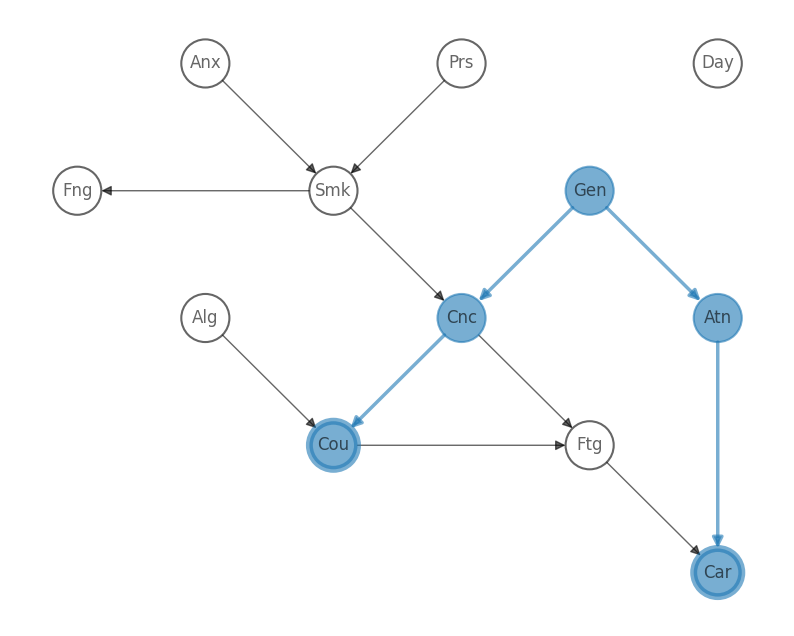

In [184]:
# colors = ['black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'r', 'r', 'black', 'r']
# nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)
visualize_paths(G, all_paths = [['Cou', 'Cnc', 'Gen', 'Atn', 'Car']], source_node = 'Cou', target_node = 'Car')


In [185]:
# def visualize_nodes(G, nodes, source_node):

#     nrows = 1
#     ncols = 1
#     x_size = 5
#     y_size = 4

#     fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(x_size*2, y_size*2))

#     edge_color = ['black' for edge in G.edges()]
#     edge_widths = [2.5 for edge in G.edges()]
#     node_color = ['#1f78b4' if node in nodes else 'white' for node in G.nodes()]
#     edge_colors = ['#1f78b4' if node in nodes else 'black' for node in G.nodes()]
#     line_widths = [5 if node in source_node else 1.5 for node in G.nodes()]
#     nx.draw(G,pos=pos, with_labels=True, ax=axs, edge_color=edge_color,node_size=1200, node_color=node_color, edgecolors = edge_colors, node_shape="o", alpha=0.6, linewidths=line_widths, width=edge_widths, arrowsize=15)

#     plt.figure(figsize=(8,6))
#     fig.savefig("./graph_nodes.png", transparent=True)
    
# visualize_nodes(G, nodes = ['Cou', 'Cnc', 'Ftg', 'Car'], source_node = ['Cou'], target_node = 'Car')




In [186]:
# this is the path we are testing
# path = ['Can', 'Gen', 'Att', 'Acc']

In [187]:
# we create empty (for now) lists for our colliders and non-colliders
# we also create a variable for the length of the path
# colliders = np.array([])
# non_colliders = []
# path_len = len(path)

In [188]:
# # we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
# for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
#     # if there is an arrow pointing into node1 from both sides on the path, it is a collider
#     if G.has_edge(node0, node1) and G.has_edge(node2, node1):
#         colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# # we flatten the list of list
# colliders = colliders.flatten()

In [189]:
# # any node on the path (excluding the source and target) that is not a collider is a non-collider
# non_colliders = [x for x in path[1:-1] if x not in colliders]
# non_colliders = [x for x in path[1:-1] if x not in colliders]

In [190]:
# # finally, we add the information to our dataframe, with the path, colliders, and non-colliders
# adjustment_variables = adjustment_variables.append({'path':path, 'colliders': colliders, 
#                                                     'non_colliders': non_colliders}, ignore_index=True)

In [191]:
# adjustment_variables

We now can see that we need to condition on $\{Gen\}$, $\{Att\}$, or $\{Gen, Att\}$ since these are the non-colliders. There are no colliders, so no node needs to be excluded from the adjustment set.


Combining all conditions together, we have the following:

1. Condition on at least one of $Gen$ or $Att$

DoWhy can find sets satisfying the backdoor criterion automatically. We simply provide it with the graph (in .gml format). We also need to provide it with our data.

In [192]:
data

,Smk,Fng,Anx,Prs,Gen,Atn,Day,Car,Ftg,Alg,Cou,Cnc
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


In [193]:
# # a utility function to parse the .gml file to string
# def gml_to_string(file):
#     gml_str = ''
#     with open(file, 'r') as file:
#         for line in file:
#             gml_str += line.rstrip()
#     return gml_str

# from IPython.display import Image, display

# gml_graph = gml_to_string('assignment_graph.gml')
# # With GML string
# model=CausalModel(
#         data = data,
#         treatment='Cnc',
#         outcome='Car',
#         graph=gml_graph
#         )
# model.view_model()

# display(Image(filename="causal_model.png", width = 200, height = 100))

In [194]:
# identified_estimand = model.identify_effect()
# print(identified_estimand)

Under Estimand 1, we can see the adjustment set identified by DoWhy. This set will be one of those we manually found, but can differ from run to run.

DoWhy's code for finding the backdoor criterion sets is available at: https://github.com/py-why/dowhy/blob/main/dowhy/causal_identifier/backdoor.py. You can look into this a bit if you want to understand better how DoWhy finds the adjustment sets. For example, you can access all the minimum-sized and maximum-sized adjustment sets as follows:

In [195]:
# identifier = model.identifier
# identifier.identify_backdoor(model._graph, model._treatment, model._outcome)

## Tutorial 4

### Frontdoor Criterion

The frontdoor criterion is similar to the backdoor criterion, only now we move along 'forward' paths rather than 'backwards' paths. The below definition and example are from: https://medium.data4sci.com/causal-inference-part-xii-front-door-criterion-38bec5172f3e.

A set of variables **Z** is said to satisfy the front-door criterion relative to an ordered pair of variables ($X_i$, $X_j$), if:
1. **Z** intercepts all directed paths from $X_i$ to $X_j$
2. There is no unblocked backdoor path from $X_i$ to **Z**
3. All backdoor paths from **Z** to $X_j$ are blocked by $X_i$

Let's consider the same graph as in week 3 and identify possible frontdoor criterion adjustment sets for the effect of $Can$ on $Acc$.

In this tutorial, we will create a DoWhy CausalGraph object, which has many functions built-in that calculate what we did manually in the previous tutorial.

In [196]:
# import dowhy
# import pandas as pd
# from dowhy import CausalModel

# # a utility function to parse the .gml file to string
# def gml_to_string(file):
#     gml_str = ''
#     with open(file, 'r') as file:
#         for line in file:
#             gml_str += line.rstrip()
#     return gml_str

# from IPython.display import Image, display

# # NOTE
# gml_graph = gml_to_string('assignment_graph.gml')
# # With GML string
# model=CausalModel(
#         data = data,
#         treatment='Cnc',
#         outcome='Car',
#         graph=gml_graph
#         )
# model.view_model()

# display(Image(filename="causal_model.png", width = 200, height = 100))

In [197]:
# we extract the CausalGraph object from our CausalModel object
# our_causal_graph = model._graph

Now we can find an adjustment set that satisfies the frontdoor criterion. We first need all directed paths from $X$ to $Y$, as our adjustment set needs to intercept all such paths.

In [198]:
# function for finding all directed paths between the two nodes given
# our_causal_graph.get_all_directed_paths(['Cnc'], ['Car'])

In [199]:
# visualize_paths(G, all_paths = [['Cnc', 'Cou', 'Ftg', 'Car'], ['Cnc', 'Ftg', 'Car']], source_node = 'Cnc', target_node = 'Car')

In [200]:
# visualize_paths(G, all_paths =[['Ftg', 'Cou', 'Cnc', 'Gen', 'Atn', 'Car'], ['Ftg', 'Cnc', 'Gen', 'Atn', 'Car']], source_node = 'Cnc', target_node = 'Ftg')

There are two directed paths, $Fat$ is the only node that intercepts both, so the only possible adjustment set is $\{Fat\}$

#### Unblocked backdoor paths 
We need to check if there are no unblocked backdoor path from Cancer to Fatigue.

In [201]:
# c_f_backdoor_paths = our_causal_graph.get_backdoor_paths(['Cnc'], ['Ftg'])
# c_f_backdoor_paths


In [202]:
# # list for keeping track of which paths are blocked
# path_is_blocked = []

# # looping through the backdoor paths from C to F
# for path in c_f_backdoor_paths:
#     # the is_blocked function checks with a path is blocked when conditioning on the set conditioned_nodes
#     # in this case, we are not conditioning on any nodes, so give it the empty set
#     path_is_blocked.append(our_causal_graph.is_blocked(path, conditioned_nodes = []))

# path_is_blocked

# #Path is blocked since A is a collider but it's not on the ajustment set {F}

#### Check blocked backdoor paths
We need to check if all backdoor paths between Fatigue and Car accident are blocked by Lung Cancer

In [203]:
# f_a_backdoor_paths = our_causal_graph.get_backdoor_paths(['Ftg'], ['Car'])
# f_a_backdoor_paths

#### Check non-colliders
We need to check if  F <- Cough <- C <- Gen -> Att -> A is blocked by C : since C is non-collider on this path, this path is blocked by C.

In [204]:
# # list for keeping track of which paths are blocked
# path_is_blocked = []

# # looping through the backdoor paths from F to A
# for path in f_a_backdoor_paths:
#     # the is_blocked function checks with a path is blocked when conditioning on the set conditioned_nodes
#     # in this case, we are conditioning on the set [C]
#     path_is_blocked.append(our_causal_graph.is_blocked(path, conditioned_nodes = ['Cou']))

# path_is_blocked

Conclusion: The set {F} meets the front door criterion and is a valid adjustment set for measuring the effect of Cancer on Car Accidents.

### Instrumental Variables

In the case that we have unobserved confounders in some part of the graph, limiting our ability to apply backdoor or frontdoor criterion, there is potential to use instrumental variables instead. 
The conditions variable $Z$ needs to meet in order to qualify as an instrumental variable for measuring the effect of $X$ on $Y$, are the following<sup>[1]</sup>:
1. $Z$ has a causal effect on $X$
2. $Z$ affects the outcome $Y$ only through $X$
3. $Z$ and $Y$ have no common causes

[1] Instruments for Causal Inference (Hernan and Robins, 2006)

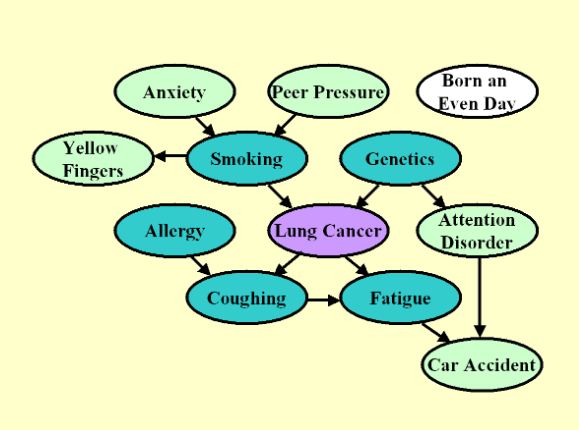

In our causal graph, since we do not have explicitly latent confounder variables, we will assume that certain variables are unobserved in order to be able to use IV's. Two situations where we could apply IV's causal effect estimation are the following:

1) (more straightforward): Z (our IV) = Allergy, X (our treatment) = Coughing, Y (our outcome) = Fatigue or Car Accident, U (our latent confounder) = Lung Cancer;

2) Z = Smoking, X = Lung Cancer, Y = Car Accident, U = Genetics.

Below, we create an instance of our causal graph once again.

We assume that the confounding variable is unobserved, and to implement this in DoWhy, we leave the latent confounder $U$ out of the dataframe. Below, we identify the variable using DoWhy.

In [205]:
# visualize_paths(G, all_paths = [['Smk', 'Cnc']], source_node = 'Smk', target_node = 'Cnc')


In [206]:
# visualize_nodes(G, nodes = ['Gen'], source_node = [])


In [207]:
# # situation 1
# iv_1_node_colors = ['w']*4 + ['lightblue'] + ['red'] + ['purple'] + ['w'] * 2 + ['yellow'] + ['w'] * 2 
# iv_1_title = 'Z = Alg, X = Cou, Y = Ftg, U = Cnc'
# nx.draw(G, pos = pos, with_labels=True, node_size=500, node_color=iv_1_node_colors, edgecolors ='black')
# plt.title(iv_1_title)
# plt.show()

In [208]:
# import random
# import statsmodels.api as sm
# random.seed(123)

# data=data.astype({'Cnc':'bool'}, copy=False)
# df_iv_1 = data[['Smk', 'Fng', 'Anx', 'Prs', 'Atn', 'Cnc', 'Day', 'Ftg', 'Alg', 'Cou', 'Car']]
# # g_iv_1 = nx.read_gml("assignment_iv_1_graph.gml")

# gml_graph = gml_to_string('assignment_graph.gml')

# model=CausalModel(
#         data = df_iv_1,
#         treatment='Cnc',
#         outcome='Car',
#         graph=gml_graph
#         )

# model.view_model()
# from IPython.display import Image, display
# display(Image(filename="causal_model.png"))

# identified_estimand = model.identify_effect()
# print(identified_estimand)


By not providing $U$ values, DoWhy recognises that the backdoor criterion cannot be used since we can no longer condition on $U$, and correctly identifies that we can use the variables in the blue nodes as IV's.

Estimating causal effects

In [209]:
# causal_estimate_reg = model.estimate_effect(identified_estimand, method_name="frontdoor.two_stage_regression")

# print(causal_estimate_reg)
# print("Causal Estimate is " + str(causal_estimate_reg.value))

In [210]:
# np.cov(data['Smk'], data['Cnc'])